# Train O-Net
- **491441** train boxes, **119633** eval boxes &ensp; **(no box is re-used)**
- EPOCH = 60
- LR = 0.001 + reduce by a factor of 0.1 against a patience of 5 epoch
- batch size = 32
- num of worker = 8
- loss configuration: 1.0 for label, 0.5 for offset


In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.functional as tf
from PIL import Image
import os.path as osp
import numpy as np
from numpy.random import uniform
import PIL
from PIL import Image, ImageDraw
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import random
import argparse
import os
import copy
import json
import warnings
warnings.filterwarnings("ignore")

## customized dataset
**1. read txt file generated by notebook *Make_ONet_data.ipynb***

txt format:<br>

`image path`||`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`|`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`......\n<br>
`image path`||`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`|`label`+`x1` `y1` `x2` `y2`+`x1^` `y1^` `x2^` `y2^`......\n<br>
......<br><br>


**2. data loading**

There are **491441** predicted boxes in **12851** images for training and **119633** boxes in **3220** images for evaluation. To make full use of the data, the customized dataset is designed to store all the boxes in lists and only a random part of the whole dataset will be used in each epoch. After each box is picked it will be **popped**, so that no box will be re-used in the same trial of training. This strategy largely helps solve overfitting and reduce the time of training. <br>

In [2]:
class OnetDataset(data.Dataset):
    def __init__(self, phase, epoch_size):
        
        self.length = epoch_size
        self.images = []
        self.offsets = []
        self.labels = []
        self.boxes = []

        file = open('/kaggle/input/-mytxt/onet_'+ phase +'.txt')    
        lines = file.readlines()

        for line in lines:

            line = line.strip()
            idx = line.find('||')
            img_path = line[:idx]
            if (not self.is_valid_image(img_path)) or (idx==-1):
                continue
            faces = line[idx+2:].split('|')  # faces = labels + boxes

            for face in faces:
                
                [label, true_box, box] = face.split('+')
                true_box=[int(i) for i in true_box.split()]
                box=[int(i) for i in box.split()]
                
                try:
                    offset = self.cal_offset(true_box,box)
                except:
                    continue
                    
                label = [1.0 if label in ['p', 'pf', 'l'] else 0.0]

                self.images.append(img_path)
                self.boxes.append(box)
                self.offsets.append(offset)
                self.labels.append(label)
                
        
    def cal_offset(self,face, box):
        
        offset = [
            (face[0] - box[0]) / float(box[2] - box[0])
            ,
            (face[1] - box[1]) / float(box[3] - box[1]),
            (face[2] - box[2]) / float(box[2] - box[0]),
            (face[3] - box[3]) / float(box[3] - box[1]),
        ]
        return offset
    
    
    def is_valid_image(self,path):
        try:
            i = Image.open(path)
            valid = True
        except:
            valid = False
        return valid


    def __getitem__(self, index):
        
        index = random.randint(0,len(self.images)-1)
        
        image = Image.open(self.images.pop(index))
        box = self.boxes.pop(index)
        crop_img = tf.resized_crop(image, box[1], box[0], box[3]-box[1]+1, box[2]-box[0]+1, (48,48), interpolation=2)
        crop_img = tf.to_tensor(crop_img)
        label = torch.FloatTensor(self.labels.pop(index))
        offset = torch.FloatTensor(self.offsets.pop(index))
        landmark = torch.FloatTensor(10 * [0.0])
        landmark_flag = torch.FloatTensor([0.0])
        
        return (crop_img, label, offset, landmark_flag, landmark)

    
    def __len__(self):
        return self.length

## O-Net

In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)
        

class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)
        self.prelu5 = nn.PReLU()
        self.conv6_1 = nn.Linear(256, 1)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark

## customized loss function
linear combination of **class loss**, **offset loss** and **lamdmark loss** (not used)

In [4]:
class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):

        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss()
        self.loss_box = nn.MSELoss()
        self.loss_landmark = nn.MSELoss()



    def cls_loss(self, gt_label, pred_label):

        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        mask = torch.ge(gt_label, 0)        
        valid_gt_label = gt_label[mask]
        valid_pred_label = pred_label[mask]
        
        return self.loss_cls(valid_pred_label, valid_gt_label) * self.cls_factor
    
    

    def box_loss(self, gt_label, gt_offset, pred_offset):

        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)

        mask = torch.eq(gt_label, 1)

        valid_gt_offset = gt_offset[mask, :]
        valid_pred_offset = pred_offset[mask, :]
        valid_sample_num = valid_gt_offset.shape[0]
        if 0 == valid_sample_num:

            return torch.tensor([0.0])
        else:
            return self.loss_box(valid_pred_offset, valid_gt_offset) * self.box_factor


    def landmark_loss(self, landmark_flag, gt_landmark=None, pred_landmark=None):
        
        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(landmark_flag)
        mask = torch.eq(gt_label, 1)
        valid_gt_landmark = gt_landmark[mask, :]
        valid_pred_landmark = pred_landmark[mask, :]
        valid_sample_num = valid_gt_landmark.shape[0]
        if 0 == valid_sample_num:
            return torch.tensor([0.0])
        else:
            return self.loss_landmark(valid_pred_landmark, valid_gt_landmark) * self.land_factor

        
    def total_loss(self, gt_label, pred_label, gt_offset, pred_offset, landmark_flag, gt_landmark, pred_landmark):
        return self.cls_loss(gt_label, pred_label) \
               + self.box_loss(gt_label, gt_offset, pred_offset) \
               + self.landmark_loss(landmark_flag, gt_landmark, pred_landmark)

In [5]:
def IoU(box, boxes):
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr

In [6]:
def visualize_accuracy(statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.show()
    fig.savefig(fig_name)

In [7]:
def train_Onet(model, criterion, optimizer, loss_config, scheduler=None):
    
    train_begin = time.time()
    min_loss = 100.0
    best_model_wts = copy.deepcopy(model.state_dict())
    statistics = {'train':([],[]), 'eval':([],[])} # 'train':([loss],[acc])
    iter_count = 0
    

    for epoch in range(EPOCH):
        print('Epoch {}/{}'.format(epoch, EPOCH - 1))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        
        for (img_tensor, label, offset, landmark_flag, landmark) in O_trainLoader:
            
            iter_count += 1
            iter_begin = time.time()
            
            wrap = (img_tensor, label, offset, landmark)
            (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
            det, box, ldmk = model(img_tensor)
            if landmark==None:
                ldmk=None
            optimizer.zero_grad()
            all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                       landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
            
            iter_length = time.time() - iter_begin

            all_loss.backward()
            optimizer.step()
            
            running_loss += all_loss.item() * img_tensor.size(0)
            
        epoch_loss = running_loss / O_trainSize
        statistics['train'][0].append(epoch_loss)
        if scheduler is not None:
            scheduler.step(epoch_loss)
            lr = optimizer.param_groups[0]['lr']
        print('Train Loss: {:.4f} Acc: NA lr: {:.7f}'.format(epoch_loss,lr))
        
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_acc = 0.0

            for (img_tensor, label, offset, landmark_flag, landmark) in O_evalLoader:

                wrap = (img_tensor, label, offset, landmark)
                (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
                det, box, ldmk = model(img_tensor)
                if landmark==None:
                    ldmk=None
                all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                           landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)

                running_loss += all_loss.item() * img_tensor.size(0)

            epoch_loss = running_loss / O_evalSize
            statistics['eval'][0].append(epoch_loss)
            print('Eval Loss: {:.4f} Acc: NA'.format(epoch_loss))
        print()
        
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    train_length = time.time() - train_begin
    print('Training complete in {:.0f}m {:.0f}s'.format(train_length // 60, train_length % 60))
    print('Min train loss: {:4f}'.format(min_loss))
    best_model = copy.deepcopy(model)
    best_model.load_state_dict(best_model_wts)
    
    return best_model, model, statistics

## assign parameters and start training
Here, the coefficient of class loss is set to 1. One can increase this coefficient to emphasize the correctness of class prediction.

In [8]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

LR = 0.001
EPOCH = 60
BATCH_SIZE = 32
NUM_WORKS = 8
Onet_loss_config = [1.0, 0.5, 0.5]


O_trainset = OnetDataset('train',6000)
O_trainLoader = DataLoader(O_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

O_evalset = OnetDataset('eval',1000)
O_evalLoader = DataLoader(O_evalset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

O_trainSize = len(O_trainset)
O_evalSize = len(O_evalset)
print(O_trainSize)
print(O_evalSize)

model = O_Net().cuda()

for param in model.conv6_3.parameters():
    param.requires_grad = False
    
optimizer = opt.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = LossFn(cls_factor=Onet_loss_config[0], box_factor=Onet_loss_config[1], landmark_factor=Onet_loss_config[2])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, cooldown=2, min_lr=1e-08)

6000
1000


In [9]:
model, final_model, statistics = train_Onet(model, criterion, optimizer, Onet_loss_config, scheduler)

Epoch 0/59
----------
Train Loss: 0.4960 Acc: NA lr: 0.0010000
Eval Loss: 0.5135 Acc: NA

Epoch 1/59
----------
Train Loss: 0.4015 Acc: NA lr: 0.0010000
Eval Loss: 0.3554 Acc: NA

Epoch 2/59
----------
Train Loss: 0.3588 Acc: NA lr: 0.0010000
Eval Loss: 0.3187 Acc: NA

Epoch 3/59
----------
Train Loss: 0.2969 Acc: NA lr: 0.0010000
Eval Loss: 0.2883 Acc: NA

Epoch 4/59
----------
Train Loss: 0.3075 Acc: NA lr: 0.0010000
Eval Loss: 0.2979 Acc: NA

Epoch 5/59
----------
Train Loss: 0.2529 Acc: NA lr: 0.0010000
Eval Loss: 0.2437 Acc: NA

Epoch 6/59
----------
Train Loss: 0.2364 Acc: NA lr: 0.0010000
Eval Loss: 0.2128 Acc: NA

Epoch 7/59
----------
Train Loss: 0.2262 Acc: NA lr: 0.0010000
Eval Loss: 0.2031 Acc: NA

Epoch 8/59
----------
Train Loss: 0.2229 Acc: NA lr: 0.0010000
Eval Loss: 0.2557 Acc: NA

Epoch 9/59
----------
Train Loss: 0.2025 Acc: NA lr: 0.0010000
Eval Loss: 0.1783 Acc: NA

Epoch 10/59
----------
Train Loss: 0.1903 Acc: NA lr: 0.0010000
Eval Loss: 0.1695 Acc: NA

Epoch 11/

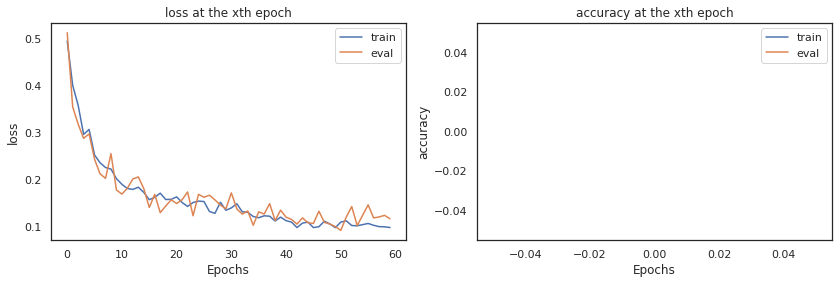

In [10]:
name = 'ONet_f1'
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')
json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(statistics, name)